In [17]:
import os
import re
import pandas as pd

# ================== 配置 ================== 
# root_dir = os.path.dirname(os.path.abspath(''))
root_dir = os.getcwd()

# //拼接路径
BASE_DIR = os.path.join(root_dir, "reports")
OUTPUT_CSV = os.path.join(root_dir, "output", "investment_analysis.csv")
print("开始处理：报告根目录：",BASE_DIR,"输出CSV文件：", OUTPUT_CSV)
# BASE_DIR = "d:\\999-桌面\\homework\\homework\\reports"

# # BASE_DIR = "./reports"
# OUTPUT_CSV = "d:\\999-桌面\\homework\\homework\\output\\investment_analysis.csv"

# 区域映射
def get_region_label(name):
    name = name.strip()
    if "东部" in name: return "东部"
    if "中部" in name: return "中部"
    if "西部" in name: return "西部"
    return "未知区域"

# # 支出方向关键词
EXPENSE_KEYWORDS = {
    'human': [
          # === 新增：财政部标准功能支出科目（核心！）===
    '教育支出',
    '社会保障和就业支出',
    '卫生健康支出',
    '节能环保支出',          # 🔹 含环境治理、生态惠民
    '公共安全支出',          # 🔹 公安、司法、消防、法律援助
    '科学技术支出',          # 🔹 基础科研、人才计划
    '文化旅游体育与传媒支出', # 🔹 文化惠民、体育设施
    '农林水支出',            # 🔹 乡村振兴、农村医保、农民补贴
    '商业服务业等支出',       # 🔹 中小企业扶持、消费促进（偏 human）
    '城乡社区支出',          # 🔹 社区服务、公园、环卫（非基建部分）
    '住房保障支出',          # 🔹 公租房、棚改（明确 human）
        # 社会保障与救助
        '养老', '医保', '社保', '低保', '救助', '困难群众', '残疾人',
        '保障', '待遇', '公益性岗位', '失业', '救济',
        # 就业与人才
        '就业', '培训', '职业技能', '人才津贴', '引进人才', '创业扶持',
        # 教育
        '教育', '教学', '教师', '学生', '助学金', '义务教育', '高等教育', '职教',
        # 医疗卫生
        '医疗', '卫生', '医院', '疾控', '妇幼', '公卫服务', '公共卫生',
        # 文化惠民
        '文化惠民', '免费开放', '图书馆', '博物馆', '体育',
        # 补贴类（需结合上下文，但高频）
        '补贴', '补助', '奖励', '资助','棚户区改造', '棚改', '安置房', '住房保障'

    ],
    'physical': [
        # 基础设施
        '基础设施', '道路', '桥梁', '管网', '污水处理', '垃圾处理',
        '绿化', '亮化', '农田水利', '高标准农田',
        # 建设与工程
        '建设', '改造', '修缮', '征地拆迁',
        # 设备与资产
        '购置', '设施', '仪器设备', '车辆', '标准化厂房',
        # 新型基建与产业
        '智慧城市', '大数据中心', '新基建', '5G', '数据中心',
        # 物流与农业基建
        '仓储物流', '网络建设'
        # 注意：棚改、安置房已移至 human
    ]
}
# EXPENSE_KEYWORDS = {
#     'human': [
#         # === 财政大类（优先匹配）===
#         '教育支出', '社会保障和就业', '卫生健康',
#         '文化旅游体育与传媒', '农林水',  # 注：农林水中含大量民生
#         # === 子项关键词（补充）===
#         '教育', '学校', '教师', '学生', '职教', '高等教育', '义务教育','城乡',
#         '医疗', '卫生', '健康', '医院', '医保', '疾控', '妇幼', '公共卫生','社区',
#         '养老', '社保', '低保', '就业', '失业', '残疾人', '托育', '儿童','社会保障',
#         '人才', '引进', '补贴', '安家费', '创业扶持',
#         '文化', '体育', '图书馆', '博物馆', '社区服务', '法律援助',
#         '乡村振兴', '农民', '农村', '农业技术推广'  # 农林水中的民生部分
#     ],
#     'physical': [
#         # === 财政大类 ===
#         '交通运输', '资源勘探工业信息', '粮油物资储备',
#         # === 子项关键词 ===
#         '交通', '道路', '桥梁', '地铁', '机场', '港口', '物流', '铁路',
#         '水利', '电网', '能源', '5G', '数据中心', '新基建', '算力',
#         '产业园', '开发区', '高新区', '厂房', '工业技改',
#         '城市更新', '棚户区改造', '保障性住房', '停车场', '充电桩',
#         '智能网联汽车', '低空经济', '供应链', '仓储'
#     ]
# }


YEAR_PATTERN = re.compile(r'(202[1-5])')

# 支出相关的触发词
TRIGGER_WORDS = r'(?:支出|投入|安排|拨付|用于|下达|列支|预算|决算|资金|经费|扶持|补贴|资助)'

# 金额正则（带上下文）
AMOUNT_PATTERN = re.compile(
    f'({TRIGGER_WORDS})[^\\d]*?'  # 触发词后允许非数字字符（如冒号、空格）
    r'(\d{{1,3}}(?:,\d{{3}})*(?:\.\d+)?|\d+(?:\.\d+)?)\s*(亿|万)?\s*元',
    re.IGNORECASE
) 


def extract_amount_and_category(sentence):
    # 在函数开头加：特殊处理：“一般公共预算支出”等总述句
    if any(excl in sentence for excl in ['一般公共预算支出', '总计', '合计', ' total ', '共安排', '政府性基金支出', '国有资本经营支出', '全年支出',]):
        return None, None, None
    
    """从句子中提取金额（转为“万元”）和支出类别"""
    match = AMOUNT_PATTERN.search(sentence)
    if not match:
        return None, None, None
    
    
       # match.group(1) 是触发词（如“支出”），我们不需要
    num_str = match.group(2).replace(',', '')
    unit = match.group(3) or ''
    
        # 先清理逗号（即使正则已过滤，再保险一次）
    clean_num_str = num_str.replace(',', '')
    if not re.fullmatch(r'\d+(\.\d+)?', clean_num_str):
        return None, None, None

    try:
        num = float(num_str)
        if unit == '亿':
            amount_wan = num * 10000
        elif unit == '万':
            amount_wan = num
        else:  # 单位是“元”
            amount_wan = num / 10000
    except ValueError:
        return None, None, None
    # print(f"DEBUG: sentence='{sentence}',num_str='{num_str}', unit='{repr(unit)}', num={num}")

  # 清理句子（去空格，便于关键词匹配）
    clean_sent = sentence.replace(' ', '').replace('　', '')  # 全角空格
        # 优先匹配 human（因民生更常见，且避免被 physical 动词干扰）
    for kw in EXPENSE_KEYWORDS['human']:
        if kw in clean_sent:
            return amount_wan, 'human', kw

    for kw in EXPENSE_KEYWORDS['physical']:
        if kw in clean_sent:
            return amount_wan, 'physical', kw
    # 未明确的当作人TODO:
    # return None,None,None
    return amount_wan, 'physical', '未明确方向'

# === 主流程 ===
all_records = []

# 获取所有 (region, city) 对
city_list = []
for region_folder in os.listdir(BASE_DIR):
    region_path = os.path.join(BASE_DIR, region_folder)
    if not os.path.isdir(region_path):
        continue
    for city_folder in os.listdir(region_path):
        city_path = os.path.join(region_path, city_folder)
        if os.path.isdir(city_path):
            city_list.append((region_folder, city_folder))

total_cities = len(city_list)
print(f"📊 共发现 {total_cities} 个城市，开始处理...\n")

for idx, (region_folder, city_folder) in enumerate(city_list, 1):
    region_path = os.path.join(BASE_DIR, region_folder)
    city_path = os.path.join(region_path, city_folder)

    region_label = get_region_label(region_folder)
    city_name = city_folder.rstrip('市')

    print(f"[{idx}/{total_cities}] 🏙️ 正在处理: {city_name} ({region_label})")

    city_records = []
    
    # 在城市循环内，先收集所有有效财政文件（按年份分组）
    yearly_files = {}  # {2023: {'budget': 'xxx.txt', 'final': 'yyy.txt'}, ...}

    # 只处理 .txt 文件
    for filename in os.listdir(city_path):
        if filename.startswith('.'):
            continue
        if not filename.lower().endswith('.txt'):
            continue
        # 忽略工作报告
        if "工作报告" in filename.lower():
            continue

        # filepath = os.path.join(city_path, filename)

        # 从文件名提取年份
        year_match = YEAR_PATTERN.search(filename)
        if not year_match:
            continue
        year = int(year_match.group(1))
        if year not in yearly_files:
            yearly_files[year] = {'budget': None, 'final': None}
        if "决算" in filename:
            yearly_files[year]['final'] = filename
        elif "预算" in filename:
            yearly_files[year]['budget'] = filename
    for year, files in yearly_files.items():
    # 优先决算，其次预算
        chosen_file = files['final'] or files['budget']
        if not chosen_file:
            continue

        file_type = "财政决算报告" if files['final'] else "财政预算报告"
        filepath = os.path.join(city_path, chosen_file)

    # 读取并处理该文件（后续逻辑不变）

        # # 判断文件类型
        # if "工作" in filename:
        #     file_type = "政府工作报告"
        #     continue
        # elif "决算" in filename or "预算" in filename:
        #     file_type = "财政预决算报告"
        # else:
        #     continue

        # 读取 TXT 文件
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                text = f.read()
        except UnicodeDecodeError:
            try:
                with open(filepath, 'r', encoding='utf-8-sig') as f:
                    text = f.read()
            except Exception:
                print(f"  ⚠️ 编码错误，跳过: {filename}")
                continue
        except Exception as e:
            print(f"  ⚠️ 读取失败: {filename} | {e}")
            continue

        # 按段落分割（空行或换行）
        paragraphs = re.split(r'\n\s*\n', text)
        sentences = []
        for para in paragraphs:
            para = para.strip()
            if not para:
                continue
            # 再按中文句号、分号、感叹号、问号、换行符等分割成句子
            # 注意：避免在数字中间切（如“1.5亿元”），但中文环境下通常用“。”而非“.”
            sub_sents = re.split(r'[；;。！!？?\n\r]+', para)
            for s in sub_sents:
                s = s.strip()
                if s and len(s) >= 10:  # 过滤太短的碎片
                    sentences.append(s)
        for sentence in sentences:
        # for para in paragraphs:
            # para = para.strip()
            sentence=sentence.strip()
            if not sentence or len(sentence) < 10 or "收入" in sentence:
                continue

            amount, cat, kw = extract_amount_and_category(sentence)
            if amount is not None and amount >= 100:  # 至少100万元
                city_records.append({
                    "区域": region_label,
                    "城市": city_name,
                    "年份": year,
                    "文件类型": file_type,
                    "支出类别": cat,
                    "匹配关键词": kw,
                    "原文片段": sentence[:250].replace('\n', ' '),
                    "金额（万元）": round(amount, 2),
                    "页码": None,
                    "文件名": filename
                })

    all_records.extend(city_records)
    print(f"  ✅ 完成 {city_name}，新增 {len(city_records)} 条记录，累计 {len(all_records)} 条")

    # 实时保存
    os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)
    df = pd.DataFrame(all_records)
    df.to_csv(OUTPUT_CSV, index=False, encoding='utf_8_sig')
    print(f"  💾 已保存至: {OUTPUT_CSV}\n")

开始处理：报告根目录： d:\wkstation\python\homework2\homework\reports 输出CSV文件： d:\wkstation\python\homework2\homework\output\investment_analysis.csv
📊 共发现 17 个城市，开始处理...

[1/17] 🏙️ 正在处理: 上海 (东部)
  ✅ 完成 上海，新增 230 条记录，累计 230 条
  💾 已保存至: d:\wkstation\python\homework2\homework\output\investment_analysis.csv

[2/17] 🏙️ 正在处理: 北京 (东部)
  ✅ 完成 北京，新增 981 条记录，累计 1211 条
  💾 已保存至: d:\wkstation\python\homework2\homework\output\investment_analysis.csv

[3/17] 🏙️ 正在处理: 广州 (东部)
  ✅ 完成 广州，新增 404 条记录，累计 1615 条
  💾 已保存至: d:\wkstation\python\homework2\homework\output\investment_analysis.csv

[4/17] 🏙️ 正在处理: 杭州 (东部)
  ✅ 完成 杭州，新增 567 条记录，累计 2182 条
  💾 已保存至: d:\wkstation\python\homework2\homework\output\investment_analysis.csv

[5/17] 🏙️ 正在处理: 济南 (东部)
  ✅ 完成 济南，新增 214 条记录，累计 2396 条
  💾 已保存至: d:\wkstation\python\homework2\homework\output\investment_analysis.csv

[6/17] 🏙️ 正在处理: 深圳 (东部)
  ✅ 完成 深圳，新增 179 条记录，累计 2575 条
  💾 已保存至: d:\wkstation\python\homework2\homework\output\investment_analysis.csv

[7/17] 🏙️ 正在处理: 苏州 (东部)
 

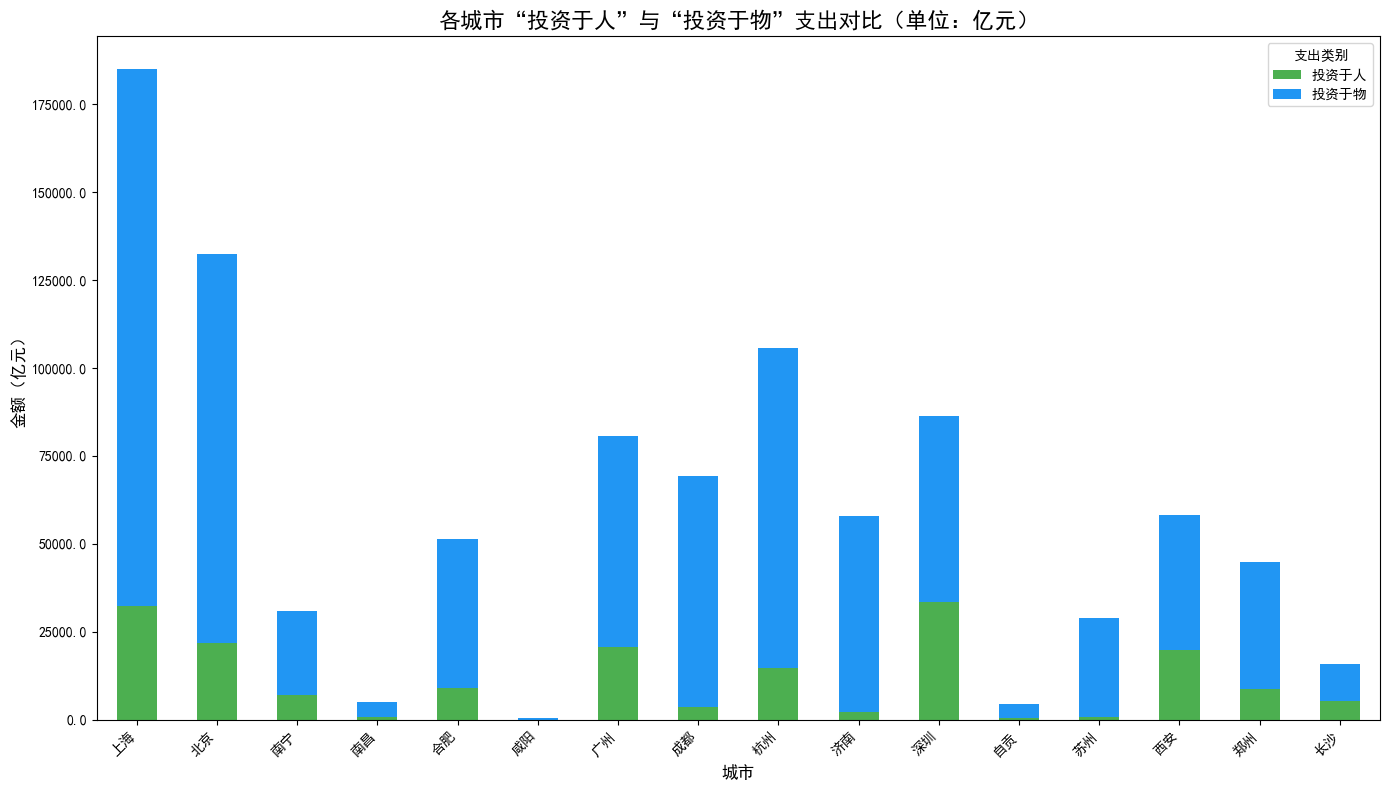

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = [
    'PingFang SC',
    'Heiti SC',
    'SimHei',
    'Arial Unicode MS'
]
 

# 读取数据

df = pd.read_csv(OUTPUT_CSV)

# 只保留有金额的记录（排除定性分析行）
df_amount = df.dropna(subset=['金额（万元）'])

# 将“万元”转换为“亿元”用于显示（1 亿元 = 10000 万元）
df_amount['金额（亿元）'] = df_amount['金额（万元）'] / 10000

# 按城市和类别汇总（单位：亿元）
city_totals = df_amount.groupby(['城市', '支出类别'])['金额（亿元）'].sum().unstack(fill_value=0)

# 绘图
ax = city_totals.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    color=['#4CAF50', '#2196F3']  # human: green, physical: blue
)

# 设置标题和标签
plt.title('各城市“投资于人”与“投资于物”支出对比（单位：亿元）', fontsize=16)
plt.xlabel('城市', fontsize=12)
plt.ylabel('金额（亿元）', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(['投资于人', '投资于物'], title='支出类别')

# 格式化 Y 轴：保留1位小数
from matplotlib.ticker import FuncFormatter
def billions(x, pos):
    return f'{x:.1f}'
ax.yaxis.set_major_formatter(FuncFormatter(billions))

plt.tight_layout()
plt.show()

In [16]:
import os   
root_dir = os.path.dirname(os.path.abspath('.'))
print(os.getcwd())
print(root_dir)
# //拼接路径
BASE_DIR = os.path.join(root_dir, "reports")
OUTPUT_CSV = os.path.join(root_dir, "output", "investment_analysis.csv")
print(BASE_DIR, OUTPUT_CSV)



d:\wkstation\python\homework2\homework
d:\wkstation\python\homework2
d:\wkstation\python\homework2\reports d:\wkstation\python\homework2\output\investment_analysis.csv
